__Основное задание:__

_Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов -_ __ROC-AUC,__ _название целевой переменной -_ __IsFraud.__ _Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые._ __Внимание!__ _выборка assignment_2_test.csv - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации._ __Для других целей использовать выборку запрещено!.__


__Терминалогия, используемая в задании:__

_* обучающая выборка - выборка, которая передается в метод fit / train;_

_* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (train, valid);_

_* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);_

_* ЛБ - лидерборд, выборка assignment_2_test.csv._

__Задание 1:__ _сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы._

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
data = pd.read_csv("data/assignment_2_train.csv")
leaderboard = pd.read_csv("data/assignment_2_test.csv")

print("data.shape = {} rows, {} cols".format(*data.shape))
print("leaderboard.shape = {} rows, {} cols".format(*leaderboard.shape))

data.shape = 180000 rows, 394 cols
leaderboard.shape = 100001 rows, 394 cols


In [3]:
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
target = "isFraud"
numerical_features = data.drop(columns=target).select_dtypes(include=[np.number]).columns
data = data.sort_values(by="TransactionID")

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(data.drop(columns=[target]),
                                                      data[target],
                                                      test_size=.3,
                                                      shuffle=False)


print(f'Train size: {x_train.shape[0]:>5} - ({x_train.shape[0]/data.shape[0]:.0%})')
print(f'Valid size: {x_valid.shape[0]:>6} - ({x_valid.shape[0]/data.shape[0]:.0%})')

Train size: 126000 - (70%)
Valid size:  54000 - (30%)


In [6]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": -1,
    "seed": 27
}

In [7]:
dtrain = xgb.DMatrix(data=x_train[numerical_features], label=y_train)
dvalid = xgb.DMatrix(data=x_valid[numerical_features], label=y_valid)

In [8]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=20,
    maximize=True,
)

[0]	train-auc:0.602367	valid-auc:0.621388
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[20]	train-auc:0.824025	valid-auc:0.830786
[40]	train-auc:0.869195	valid-auc:0.851911
[60]	train-auc:0.887319	valid-auc:0.865032
[80]	train-auc:0.894206	valid-auc:0.868984
[100]	train-auc:0.898754	valid-auc:0.87162
[120]	train-auc:0.901792	valid-auc:0.873412
[140]	train-auc:0.903837	valid-auc:0.874409
Stopping. Best iteration:
[133]	train-auc:0.903837	valid-auc:0.874409



In [9]:
pred_train = model.predict(xgb.DMatrix(x_train[numerical_features]))
pred_valid = model.predict(xgb.DMatrix(x_valid[numerical_features]))
pred_lb = model.predict(xgb.DMatrix(leaderboard[numerical_features]))

print(f"Train-score: {round(roc_auc_score(y_train, pred_train), 5):>13}\n"
      f"Valid-score: {round(roc_auc_score(y_valid, pred_valid), 5):>13}\n"
      f"Leaderboard-score: {round(roc_auc_score(leaderboard[target], pred_lb), 5):>7}")

Train-score:       0.90384
Valid-score:       0.87441
Leaderboard-score: 0.85919


Качество на валидационной выборке ниже, чем на обучающей, это говорит о небольшом переобучении модели. Качество на ЛБ ниже, чем на валидационной, это связано как с меньшим объемом выборки, так и с тем, что ЛБ выборка не участвовала в обучении.

__Задание 2:__ _сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки._

In [10]:
x_train, x_valid_test, y_train, y_valid_test = train_test_split(data.drop(columns=[target]),
                                                                data[target],
                                                                test_size=.4,
                                                                shuffle=False)

x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size=.65, shuffle=False)

print(f'Train size: {x_train.shape[0]:>6} - ({x_train.shape[0]/data.shape[0]:.0%})')
print(f'Valid size: {x_valid.shape[0]:>6} - ({x_valid.shape[0]/data.shape[0]:.0%})')
print(f'Test size: {x_test.shape[0]:>7} - ({x_test.shape[0]/data.shape[0]:.0%})')

Train size: 108000 - (60%)
Valid size:  25200 - (14%)
Test size:   46800 - (26%)


In [11]:
dtrain = xgb.DMatrix(data=x_train[numerical_features], label=y_train)
dvalid = xgb.DMatrix(data=x_valid[numerical_features], label=y_valid)

In [12]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=20,
    maximize=True,
)

[0]	train-auc:0.604832	valid-auc:0.59622
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[20]	train-auc:0.811215	valid-auc:0.794206
[40]	train-auc:0.871443	valid-auc:0.857235
[60]	train-auc:0.888684	valid-auc:0.869488
[80]	train-auc:0.895684	valid-auc:0.873541
[100]	train-auc:0.899665	valid-auc:0.874048
Stopping. Best iteration:
[91]	train-auc:0.898071	valid-auc:0.874623



In [13]:
pred_train = model.predict(xgb.DMatrix(x_train[numerical_features]))
pred_valid = model.predict(xgb.DMatrix(x_valid[numerical_features]))
pred_test = model.predict(xgb.DMatrix(x_test[numerical_features]))
pred_lb = model.predict(xgb.DMatrix(leaderboard[numerical_features]))

print(f"Train-score: {round(roc_auc_score(y_train, pred_train), 5):>13}\n"
      f"Valid-score: {round(roc_auc_score(y_valid, pred_valid), 5):>13}\n"
      f"Test-score: {round(roc_auc_score(y_test, pred_test), 5):>14}\n"
      f"Leaderboard-score: {round(roc_auc_score(leaderboard[target], pred_lb), 5):>7}")

Train-score:       0.89989
Valid-score:       0.87389
Test-score:        0.86421
Leaderboard-score: 0.85587


Качество на ЛБ выборке приближено к тестовой выборке, т.к. тестовая не участвовала в обучении модели.

__Задание 3:__ _построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы._

In [14]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [15]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, pred_test, roc_auc_score)

calculate_confidence_interval(scores)

(0.8537611962888333, 0.8749215252000783)

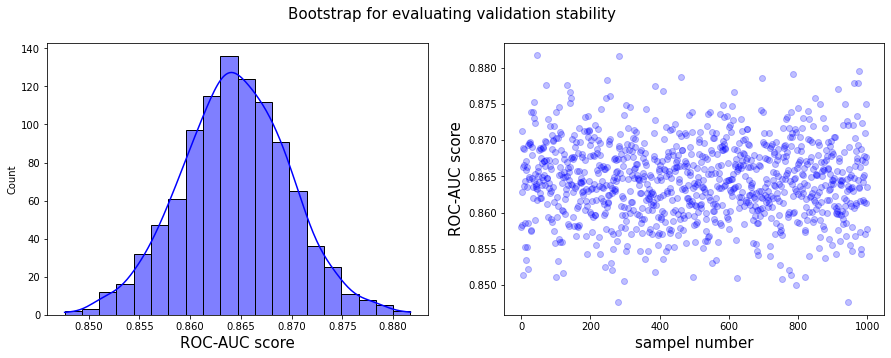

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("ROC-AUC score", size=15)

sns.histplot(scores, ax=axes[0], color="b", bins=20, kde=True)
axes[0].set_xlabel("ROC-AUC score", size=15);

Мы получили очень узкий доверительный интервал и значение качества на ЛБ выборке в него попадает, что говорит об эффективности использования Hold-Out валидации с разбиением на 3 выборки для прогнозирования качества на ЛБ выборке по тестовой выборке.

__Задание 4:__ _выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах._

In [17]:
adv = pd.concat([data, leaderboard], keys=[0, 1]) # data=0, leaderboard=1
y_adv = adv.index.droplevel(1).to_numpy()

In [18]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(adv[numerical_features], y_adv);

In [19]:
y_pred_adv = model.predict_proba(adv[numerical_features])
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

1.0


In [20]:
y_pred = model.predict_proba(data[numerical_features])
pd.cut(y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)).value_counts().sort_index()

(0.0, 0.1]    180000
(0.1, 0.2]         0
(0.2, 0.3]         0
(0.3, 0.4]         0
(0.4, 0.5]         0
(0.5, 0.6]         0
(0.6, 0.7]         0
(0.7, 0.8]         0
(0.8, 0.9]         0
(0.9, 1.0]         0
dtype: int64

Модель легко классифицирует выборки, т.к. есть значения переменных, которые явно указывают на выборку, удалим их из выборок.

In [21]:
drop_list = ['TransactionID', 'TransactionDT']
adv = pd.concat([data, leaderboard], keys=[0, 1]).drop(columns=drop_list) # data=0, leaderboard=1
y_adv = adv.index.droplevel(1).to_numpy()

In [22]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(adv[np.setdiff1d(numerical_features, drop_list)], y_adv);

In [23]:
y_pred_adv = model.predict_proba(adv[np.setdiff1d(numerical_features, drop_list)])
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.8408


In [24]:
del adv # освобождение части RAM

In [25]:
y_pred = model.predict_proba(data[np.setdiff1d(numerical_features, drop_list)])
pd.cut(y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)).value_counts().sort_index()

(0.0, 0.1]        0
(0.1, 0.2]    57969
(0.2, 0.3]    59036
(0.3, 0.4]    38846
(0.4, 0.5]    23629
(0.5, 0.6]      136
(0.6, 0.7]       36
(0.7, 0.8]       47
(0.8, 0.9]      300
(0.9, 1.0]        1
dtype: int64

In [26]:
valid_size = 0.3
idx_valid = y_pred[:, 1].argsort()[::-1][:int(valid_size*len(y_pred[:, 1]))] # индексы наиболее похожих объектов

print("Индексы наиболее похожих объектов:\n", idx_valid, "\nКоличество индексов:\n", len(idx_valid))

idx_valid.sort() # сортировка для сохранения первоначального порядка наблюдений
idx_train = np.setdiff1d(range(data.shape[0]), idx_valid) # остальные индексы

Индексы наиболее похожих объектов:
 [173752 177036 163066 ...  69967  29290 157024] 
Количество индексов:
 54000


In [27]:
x_train, y_train = data.loc[idx_train][numerical_features], data.loc[idx_train][target]
x_valid, y_valid = data.loc[idx_valid][numerical_features], data.loc[idx_valid][target]

print(f'Train size: {x_train.shape[0]:>5} - ({x_train.shape[0]/data.shape[0]:.0%})')
print(f'Valid size: {x_valid.shape[0]:>6} - ({x_valid.shape[0]/data.shape[0]:.0%})')

Train size: 126000 - (70%)
Valid size:  54000 - (30%)


In [28]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

In [29]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=20,
    maximize=True,
)

[0]	train-auc:0.599312	valid-auc:0.64508
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[20]	train-auc:0.790071	valid-auc:0.843913
[40]	train-auc:0.854778	valid-auc:0.864757
[60]	train-auc:0.875963	valid-auc:0.875432
[80]	train-auc:0.883793	valid-auc:0.879641
[100]	train-auc:0.889773	valid-auc:0.882052
[120]	train-auc:0.893146	valid-auc:0.883235
[140]	train-auc:0.895111	valid-auc:0.883701
Stopping. Best iteration:
[143]	train-auc:0.895561	valid-auc:0.884047



In [30]:
pred_train = model.predict(xgb.DMatrix(x_train))
pred_valid = model.predict(xgb.DMatrix(x_valid))
pred_lb = model.predict(xgb.DMatrix(leaderboard[numerical_features]))

print(f"Train-score: {round(roc_auc_score(y_train, pred_train), 5):>13}\n"
      f"Valid-score: {round(roc_auc_score(y_valid, pred_valid), 5):>13}\n"
      f"Leaderboard-score: {round(roc_auc_score(leaderboard[target], pred_lb), 5):>7}")

Train-score:       0.89556
Valid-score:       0.88405
Leaderboard-score: 0.84911


Качество, по сравнению с заданием 1, немного хуже на тренировочной и ЛБ выборках, и выше на валидационной, это объясняется тем, что модель лучше подстроилась под валидационную выборку, и тем, что выборки - это временные ряды, и сами выборки были отсортированы по id транзакции, а выбирая наиболее похожие наблюдения из выборки для валидации, мы нарушили исходные распределения признаков.

__Задание 5:__ _сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы._

In [31]:
def make_cross_validation_xgb(X: pd.DataFrame,
                              y: pd.Series,
                              estimator: object,
                              params: dict,
                              metric: callable,
                              cv_strategy,
                              groups=None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    models, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])


    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y, groups)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        
        dtrain = xgb.DMatrix(data=x_train, label=y_train)
        dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

        model = estimator.train(params=params,
                                dtrain=dtrain,
                                num_boost_round=1000,
                                early_stopping_rounds=10,
                                evals=[(dtrain, "train"), (dvalid, "valid")],
                                verbose_eval=False,
                                maximize=True)
        
        y_train_pred = model.predict(xgb.DMatrix(x_train))
        y_valid_pred = model.predict(xgb.DMatrix(x_valid))

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-{metric.__name__} = {round(fold_train_scores[fold_number], 4)}\n"
            f"valid-{metric.__name__} = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        models.append(model)

    oof_score = metric(y, oof_predictions)
    print(f"CV-{metric.__name__} train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-{metric.__name__} valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-{metric.__name__} = {round(oof_score, 4)}")

    return models, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [32]:
cv_strategy = StratifiedKFold(n_splits=5)

models, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation_xgb(
    data[numerical_features], 
    data[target], 
    estimator=xgb,
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy,
    groups=None
)

Fold: 1, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.9152
valid-roc_auc_score = 0.8728
Fold: 2, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.9075
valid-roc_auc_score = 0.8926
Fold: 3, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.8853
valid-roc_auc_score = 0.8501
Fold: 4, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.8797
valid-roc_auc_score = 0.7859
Fold: 5, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.8114
valid-roc_auc_score = 0.4228
CV-roc_auc_score train: 0.8798 +/- 0.037
CV-roc_auc_score valid: 0.7648 +/- 0.175
OOF-roc_auc_score = 0.7366


In [33]:
dleader = xgb.DMatrix(leaderboard[numerical_features])
for i, model in enumerate(models, start=1):
    pred_lb = model.predict(dleader)
    print(f"Model[{i}] - Leaderboard-score: {round(roc_auc_score(leaderboard[target], pred_lb), 5)}")

Model[1] - Leaderboard-score: 0.85675
Model[2] - Leaderboard-score: 0.85676
Model[3] - Leaderboard-score: 0.85048
Model[4] - Leaderboard-score: 0.8463
Model[5] - Leaderboard-score: 0.432


Кросс-валидация неустойчивая, очень большая дисперсия ROC AUC на валидационной выборке, что говорит о неоднородности данных, и необходимости их обработки. На ЛБ модели показали похожее качество, кроме одной, которая показала низкое качество как на тренировочной выборке, так и на валидационной.

__Задание 6 (опциональное):__ _сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы._

In [34]:
data = data.sort_values(by="TransactionDT")

In [35]:
x_train, x_valid_test, y_train, y_valid_test = train_test_split(data.drop(columns=[target]),
                                                                data[target],
                                                                test_size=.4,
                                                                shuffle=False)

x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size=.65, shuffle=False)

print(f'Train size: {x_train.shape[0]:>6} - ({x_train.shape[0]/data.shape[0]:.0%})')
print(f'Valid size: {x_valid.shape[0]:>6} - ({x_valid.shape[0]/data.shape[0]:.0%})')
print(f'Test size: {x_test.shape[0]:>7} - ({x_test.shape[0]/data.shape[0]:.0%})')

Train size: 108000 - (60%)
Valid size:  25200 - (14%)
Test size:   46800 - (26%)


In [36]:
dtrain = xgb.DMatrix(data=x_train[numerical_features], label=y_train)
dvalid = xgb.DMatrix(data=x_valid[numerical_features], label=y_valid)

In [37]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=20,
    maximize=True,
)

[0]	train-auc:0.604832	valid-auc:0.59622
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[20]	train-auc:0.811215	valid-auc:0.794206
[40]	train-auc:0.871443	valid-auc:0.857235
[60]	train-auc:0.888684	valid-auc:0.869488
[80]	train-auc:0.895684	valid-auc:0.873541
[100]	train-auc:0.899665	valid-auc:0.874048
Stopping. Best iteration:
[91]	train-auc:0.898071	valid-auc:0.874623



In [38]:
pred_train = model.predict(xgb.DMatrix(x_train[numerical_features]))
pred_valid = model.predict(xgb.DMatrix(x_valid[numerical_features]))
pred_test = model.predict(xgb.DMatrix(x_test[numerical_features]))
pred_lb = model.predict(xgb.DMatrix(leaderboard[numerical_features]))

print(f"Train-score: {round(roc_auc_score(y_train, pred_train), 5):>13}\n"
      f"Valid-score: {round(roc_auc_score(y_valid, pred_valid), 5):>13}\n"
      f"Test-score: {round(roc_auc_score(y_test, pred_test), 5):>14}\n"
      f"Leaderboard-score: {round(roc_auc_score(leaderboard[target], pred_lb), 5):>7}")

Train-score:       0.89989
Valid-score:       0.87389
Test-score:        0.86421
Leaderboard-score: 0.85587


In [39]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, pred_test, roc_auc_score)

calculate_confidence_interval(scores)

(0.8536963906044648, 0.8752953295201406)

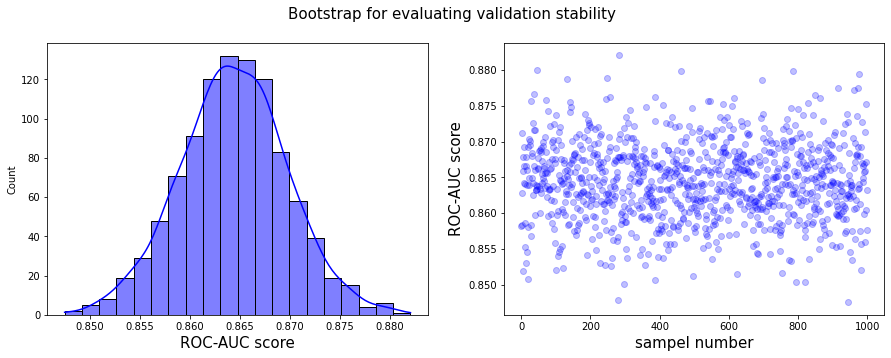

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("ROC-AUC score", size=15)

sns.histplot(scores, ax=axes[0], color="b", bins=20, kde=True)
axes[0].set_xlabel("ROC-AUC score", size=15);

Поскольку время транзакции тесно связано с ее id, то результаты идентичны п.2 и 3.

__Задание 7 (совсем опциональное):__ _в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold)._

В качестве своеобразного id клиента можно использовать категориальные переменные, т.к. id и время транзакций не привязано к определенным клиентам, числовые переменные сложно однозначно классифицировать на клиентов.

Разные значения переменных 'card6', 'ProductCD' и т.д. могут относиться к одному клиенту, т.к. он может быть держателем разных карт (Visa, MasterCard и т.д.) и эти карты могут быть разного типа ('credit', 'debit' и т.д.). Можно использовать 'P_emaildomain' и 'R_emaildomain', т.е. домены электронной почты (возможно основной "Primary" и резервный "Reserve"), т.к. это многоклассовая переменная. 

Для увеличения количества групп будем использовать конкатенацию разных категориальных переменных, которые могут классифицировать разных клиентов.

In [41]:
data.select_dtypes(exclude=[np.number]).columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [42]:
data['concat_id'] = data['P_emaildomain'].fillna(value='-') + \
    data['R_emaildomain'].fillna(value='-') + \
    data['ProductCD'].fillna(value='-') + \
    data['card4'].fillna(value='-') + \
    data['card6'].fillna(value='-')
data['concat_id'].fillna(value='-', inplace=True)

In [43]:
data['concat_id'].value_counts()

gmail.com-Wvisadebit                      24502
--Wvisadebit                              13617
yahoo.com-Wvisadebit                      12889
gmail.com-Wmastercarddebit                10630
--Wmastercarddebit                         6814
                                          ...  
verizon.netmsn.comHvisadebit                  1
comcast.neticloud.comHmastercardcredit        1
twc.comtwc.comRvisadebit                      1
aol.comsbcglobal.netHmastercarddebit          1
yahoo.deyahoo.deCvisacharge card              1
Name: concat_id, Length: 2766, dtype: int64

In [44]:
cv_strategy = GroupKFold(n_splits=5)

models, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation_xgb(
    data[numerical_features], 
    data[target], 
    estimator=xgb,
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy,
    groups=data['concat_id']
)

Fold: 1, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.9156
valid-roc_auc_score = 0.825
Fold: 2, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.9041
valid-roc_auc_score = 0.8549
Fold: 3, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.9111
valid-roc_auc_score = 0.8758
Fold: 4, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.9008
valid-roc_auc_score = 0.9262
Fold: 5, train-observations = 144000, valid-observations = 36000
train-roc_auc_score = 0.9057
valid-roc_auc_score = 0.8614
CV-roc_auc_score train: 0.9075 +/- 0.005
CV-roc_auc_score valid: 0.8687 +/- 0.033
OOF-roc_auc_score = 0.8743


In [45]:
dleader = xgb.DMatrix(leaderboard[numerical_features])
for i, model in enumerate(models, start=1):
    pred_lb = model.predict(dleader)
    print(f"Model[{i}] - Leaderboard-score: {round(roc_auc_score(leaderboard[target], pred_lb), 5)}")

Model[1] - Leaderboard-score: 0.85489
Model[2] - Leaderboard-score: 0.85299
Model[3] - Leaderboard-score: 0.85927
Model[4] - Leaderboard-score: 0.85989
Model[5] - Leaderboard-score: 0.85834


В целом качество и стабильность модели выше, что говорит об эффективности разделения выборки по своеобразному id клиента.